<a href="https://colab.research.google.com/github/Ezzeldin-nasser939/UNET_Segmentation/blob/main/UNET_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od
from skimage.util.dtype import convert
from pathlib import Path
from PIL import Image
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from glob import glob
from tqdm import tqdm
import tensorflow.image as tfi
from tensorflow.keras.utils import load_img, img_to_array


In [ ]:
od.download("https://www.kaggle.com/datasets/sakshaymahna/cityscapes-depth-and-segmentation")

100%|██████████| 642M/642M [00:21<00:00, 32.0MB/s]


In [ ]:
x_train=[]
files =Path('/content/cityscapes-depth-and-segmentation/data/train/image').glob('*')
for myFile in files:
    img=np.load(myFile, mmap_mode='r')
    img=np.array(img)
    x_train.append(img)

In [ ]:
y_train=[]
files =Path('/content/cityscapes-depth-and-segmentation/data/train/label').glob('*')
for myFile in files:
    img=np.load(myFile, mmap_mode='r')
    img=np.array(img)
    y_train.append(img)

In [ ]:
x_train=np.array(x_train)
y_train=np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(2975, 128, 256, 3)
(2975, 128, 256)


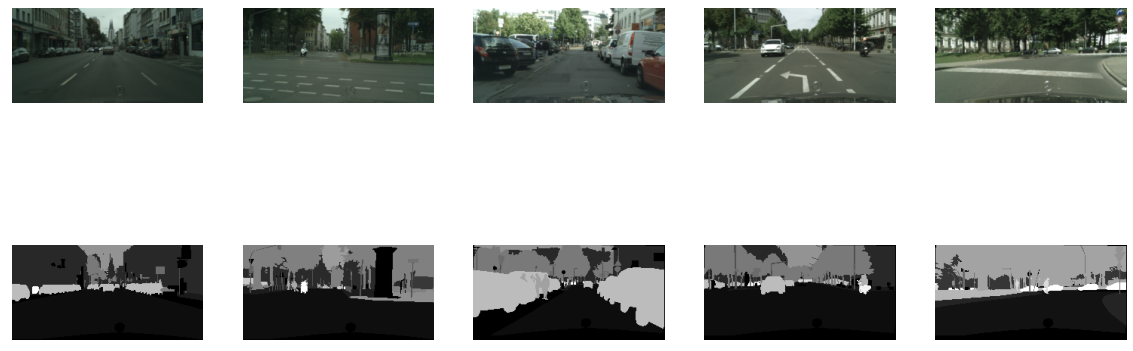

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
n = 5
plt.figure(figsize=(20, 8))
for i in range(1,n+1):
 # display original
 ax = plt.subplot(2, n, i )
 plt.imshow(x_train[i])
 plt.gray()
 ax.get_xaxis().set_visible(False)
 ax.get_yaxis().set_visible(False)
# display reconstruction
 ax = plt.subplot(2, n, i + n)
 plt.imshow(y_train[i])
 plt.gray()
 ax.get_xaxis().set_visible(False)
 ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
x_test=[]
files =Path('/content/cityscapes-depth-and-segmentation/data/val/image').glob('*')
for myFile in files:
    img=np.load(myFile, mmap_mode='r')
    img=np.array(img)
    x_test.append(img)

In [ ]:
y_test=[]
files =Path('/content/cityscapes-depth-and-segmentation/data/val/label').glob('*')
for myFile in files:
    img=np.load(myFile, mmap_mode='r')
    img=np.array(img)
    y_test.append(img)

In [ ]:
x_test=np.array(x_test)
y_test=np.array(y_test)
print(x_test.shape)
print(y_test.shape)

(500, 128, 256, 3)
(500, 128, 256)


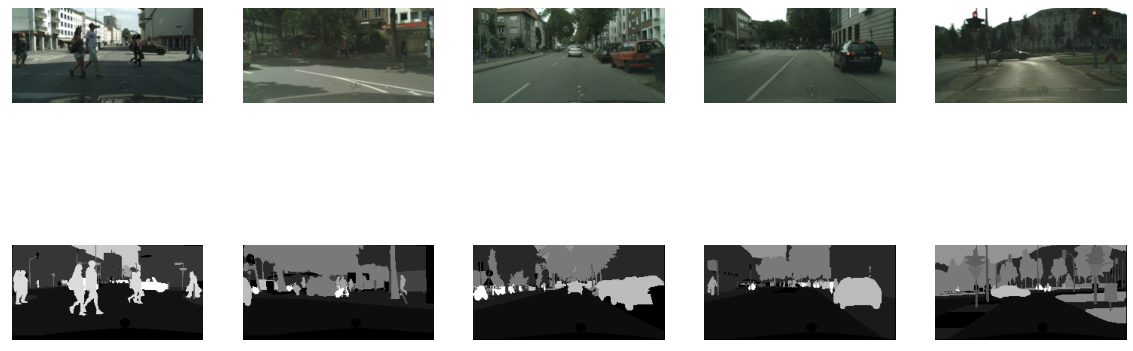

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
n = 5
plt.figure(figsize=(20, 8))
for i in range(1,n+1):
 # display original
 ax = plt.subplot(2, n, i )
 plt.imshow(x_test[i])
 plt.gray()
 ax.get_xaxis().set_visible(False)
 ax.get_yaxis().set_visible(False)
# display reconstruction
 ax = plt.subplot(2, n, i + n)
 plt.imshow(y_test[i])
 plt.gray()
 ax.get_xaxis().set_visible(False)
 ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
inputs = Input(shape=(128, 256, 3))
s = BatchNormalization()(inputs) # we can learn the normalization step
s = Dropout(0.5)(s)

c1 = Conv2D(32, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(32, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(64, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(128, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(128, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(256, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(256, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(512, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(512, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(256, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(256, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(128, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(128, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(64, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(64, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(32, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(32, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='relu') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer="adam", loss = 'mean_squared_error')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 256, 3)  12         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 dropout (Dropout)              (None, 128, 256, 3)  0           ['batch_normalization[0][0]']    
                                                                                              

In [ ]:
model.fit(x_train,y_train,
                epochs=100,
                batch_size=64,
                shuffle=True,
                validation_split=0.1)

Epoch 1/100
42/42 [==============================] - 56s 924ms/step - loss: 220.0652 - val_loss: 27.8401
Epoch 2/100
42/42 [==============================] - 27s 644ms/step - loss: 15.3418 - val_loss: 27.4199
Epoch 3/100
42/42 [==============================] - 26s 629ms/step - loss: 11.4613 - val_loss: 23.5814
Epoch 4/100
42/42 [==============================] - 26s 630ms/step - loss: 10.7295 - val_loss: 19.5832
Epoch 5/100
42/42 [==============================] - 27s 634ms/step - loss: 9.7378 - val_loss: 19.5052
Epoch 6/100
42/42 [==============================] - 26s 631ms/step - loss: 9.1671 - val_loss: 14.7936
Epoch 7/100
42/42 [==============================] - 26s 630ms/step - loss: 8.7032 - val_loss: 12.8932
Epoch 8/100
42/42 [==============================] - 26s 631ms/step - loss: 8.0816 - val_loss: 11.7371
Epoch 9/100
42/42 [==============================] - 27s 632ms/step - loss: 7.8914 - val_loss: 11.7999
Epoch 10/100
42/42 [==============================] - 26s 631ms/step

In [ ]:
pred=model.predict(x_test)

16/16 [==============================] - 3s 95ms/step


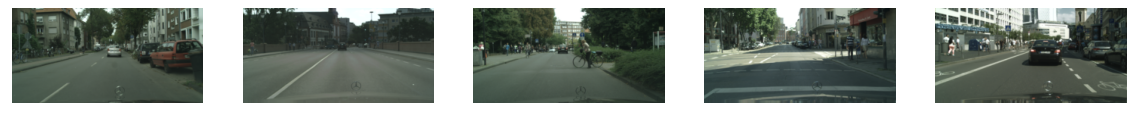

In [ ]:
n = 5  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

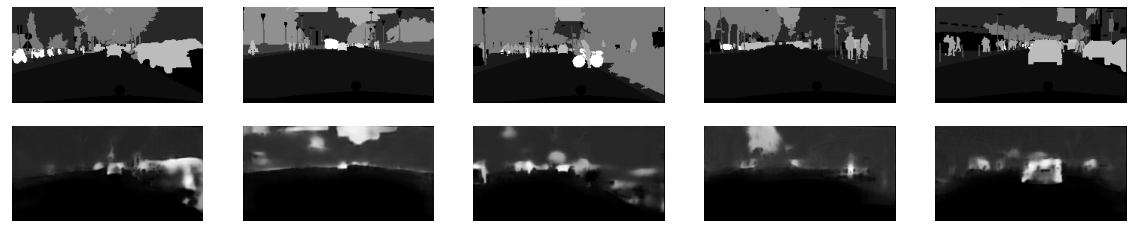

In [ ]:
n = 5  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(y_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    img=pred[i]
    img=img.reshape(128,256)
    plt.imshow(img)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()